<a href="https://colab.research.google.com/github/Rk-Pudasaini/Ktm_city_temperature_forcast_using_monte_carlo/blob/main/markov_chain_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
df = pd.read_csv('/content/Kathmandu_Daily_Climate_Data.csv')
df.head()

,YEAR,DOY,T2M,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE
0,1982,1,10.93,4.36,8.14,11.92,18.41,6.48,3.78,41.69,0.0,87.60,1.12,3.20,0.16,3.03,1.67,4.32,0.30,4.02
1,1982,2,10.20,3.57,7.24,11.12,17.26,6.15,3.54,41.00,0.0,87.45,1.17,3.52,0.08,3.45,1.66,4.73,0.07,4.66
2,1982,3,11.08,4.43,8.07,11.27,17.80,6.52,3.78,41.19,0.0,87.49,1.01,3.05,0.04,3.02,1.45,4.05,0.01,4.05
3,1982,4,13.26,6.25,10.29,10.85,20.05,9.19,4.15,39.25,0.0,87.71,1.22,3.06,0.30,2.77,1.76,4.08,0.44,3.64
4,1982,5,14.07,8.05,11.19,10.42,20.92,10.49,5.25,46.62,0.0,87.67,1.68,4.02,0.66,3.36,2.51,5.52,1.07,4.45


In [ ]:
# function to format the date columns in year- month and day type
def format_date(df):
    # Convert Year and DOY columns to datetime
    df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + df['DOY'].astype(str), format='%Y%j')

    # Format the Date column as desired (Year-Month-Day)
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Reorder columns to make "Date" the first column
    date_column = df.pop('Date')
    df.insert(0, 'Date', date_column)

    # Convert 'DATE' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Drop the "Year" and "DOY" columns
    df.drop(['YEAR', 'DOY'], axis=1, inplace=True)

    return df

df = format_date(df)
df.head()


,Date,T2M,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE
0,1982-01-01,10.93,4.36,8.14,11.92,18.41,6.48,3.78,41.69,0.0,87.60,1.12,3.20,0.16,3.03,1.67,4.32,0.30,4.02
1,1982-01-02,10.20,3.57,7.24,11.12,17.26,6.15,3.54,41.00,0.0,87.45,1.17,3.52,0.08,3.45,1.66,4.73,0.07,4.66
2,1982-01-03,11.08,4.43,8.07,11.27,17.80,6.52,3.78,41.19,0.0,87.49,1.01,3.05,0.04,3.02,1.45,4.05,0.01,4.05
3,1982-01-04,13.26,6.25,10.29,10.85,20.05,9.19,4.15,39.25,0.0,87.71,1.22,3.06,0.30,2.77,1.76,4.08,0.44,3.64
4,1982-01-05,14.07,8.05,11.19,10.42,20.92,10.49,5.25,46.62,0.0,87.67,1.68,4.02,0.66,3.36,2.51,5.52,1.07,4.45


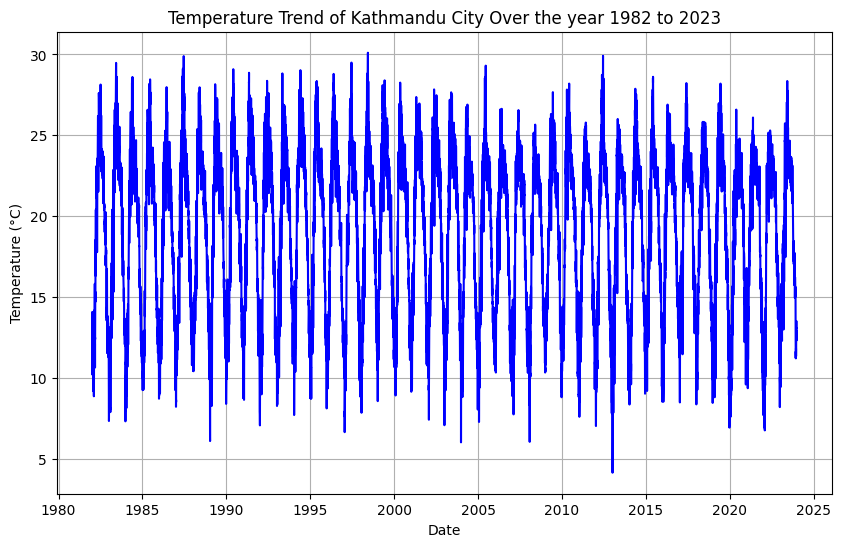

In [ ]:
# Convert 'Date' column to datetime format if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot temperature data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['T2M'], color='blue')
plt.title('Temperature Trend of Kathmandu City Over the year 1982 to 2023')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


In [ ]:
def discretize_temperature_data(df, variable='T2M', num_bins=20):
    # Discretize temperature data into bins
    temperature_data = df[variable].values
    temperature_bins = np.linspace(temperature_data.min(), temperature_data.max(), num_bins + 1)
    discretized_data = np.digitize(temperature_data, temperature_bins)
    return discretized_data, temperature_bins

# Function to train the Markov chain model
def train_markov_chain(data, order=1):
    # Initialize transition matrix
    num_states = len(set(data))
    transition_matrix = np.zeros((num_states, num_states))

    # Convert data to a list of transitions
    transitions = [(data[i], data[i + 1]) for i in range(len(data) - 1)]

    # Count occurrences of each transition
    for transition in transitions:
        current_state, next_state = transition
        transition_matrix[current_state - 1, next_state - 1] += 1

    # Normalize transition matrix
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix /= row_sums

    return transition_matrix

# Function to predict future temperature trends
def predict_temperature_trend(model, initial_state, steps=365):
    current_state = initial_state
    predicted_states = [current_state]

    for _ in range(steps):
        current_index = current_state - 1
        next_index = np.random.choice(len(model[current_index]), p=model[current_index])
        next_state = next_index + 1
        predicted_states.append(next_state)
        current_state = next_state

    return predicted_states

def plot_predicted_temperature(predicted_df):
    # Plot the predicted temperature trend
    plt.figure(figsize=(10, 6))
    plt.plot(predicted_df['Date'], predicted_df['T2M'], color='blue')
    plt.title('Predicted Temperature Trend for Kathmandu City')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.show()

def plot_actual_and_predicted_temperature(actual_df, predicted_df):

    plt.figure(figsize=(10, 6))
    plt.plot(actual_df['Date'], actual_df['T2M'], color='red', label='Actual')
    plt.plot(predicted_df['Date'], predicted_df['T2M'], color='blue', label='Predicted')
    plt.title('Actual vs Predicted Temperature Trend for Kathmandu City')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_monthly_average_predicted_temperature(predicted_df):

    monthly_avg_predicted_temp = predicted_df.groupby(predicted_df['Date'].dt.month)['T2M'].mean()
    plt.figure(figsize=(10, 6))
    monthly_avg_predicted_temp.plot(kind='bar', color='green')
    plt.title('Monthly Average Predicted Temperature')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

def compare_monthly_average_temperature(actual_df, predicted_df):

    monthly_avg_temp_actual = actual_df.groupby(actual_df['Date'].dt.month)['T2M'].mean()
    monthly_avg_predicted_temp = predicted_df.groupby(predicted_df['Date'].dt.month)['T2M'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(monthly_avg_temp_actual.index, monthly_avg_temp_actual.values, marker='o', label='Observed', color='blue')
    plt.plot(monthly_avg_predicted_temp.index, monthly_avg_predicted_temp.values, marker='s', label='Predicted', color='green')
    plt.title('Comparison of Monthly Average Temperature')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_transistion_matrix(model):
  # Plot transition probabilities using heatmap
  plt.figure(figsize=(15, 15))
  sns.heatmap(model, annot=True, cmap='Blues', fmt=".2f")
  plt.title('Transition Probabilities of Temperature States')
  plt.xlabel('To State')
  plt.ylabel('From State')
  plt.yticks(rotation=0)  # Rotate y-axis labels for better readability
  plt.show()



# Data Spliting and training the model

In [ ]:
#trainign data and testing data

In [ ]:
df.head()

,Date,T2M,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE
0,1982-01-01,10.93,4.36,8.14,11.92,18.41,6.48,3.78,41.69,0.0,87.60,1.12,3.20,0.16,3.03,1.67,4.32,0.30,4.02
1,1982-01-02,10.20,3.57,7.24,11.12,17.26,6.15,3.54,41.00,0.0,87.45,1.17,3.52,0.08,3.45,1.66,4.73,0.07,4.66
2,1982-01-03,11.08,4.43,8.07,11.27,17.80,6.52,3.78,41.19,0.0,87.49,1.01,3.05,0.04,3.02,1.45,4.05,0.01,4.05
3,1982-01-04,13.26,6.25,10.29,10.85,20.05,9.19,4.15,39.25,0.0,87.71,1.22,3.06,0.30,2.77,1.76,4.08,0.44,3.64
4,1982-01-05,14.07,8.05,11.19,10.42,20.92,10.49,5.25,46.62,0.0,87.67,1.68,4.02,0.66,3.36,2.51,5.52,1.07,4.45


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df' and has a column named 'date' for dates

# Convert the 'date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Split the dataset into training and testing based on the date
train_data = df[df['Date'].dt.year <= 2020]
test_data = df[(df['Date'].dt.year >= 2021) & (df['Date'].dt.year <= 2023)]

# Optionally, you can reset the index of both datasets
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Print the shapes of training and testing datasets to verify
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (14245, 19)
Testing data shape: (1095, 19)


In [ ]:
test_data.head()

,Date,T2M,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE
0,2021-01-01,13.61,7.27,9.40,8.92,19.42,10.49,4.82,43.75,0.0,87.76,1.11,2.98,0.16,2.81,1.59,3.98,0.34,3.64
1,2021-01-02,13.90,7.22,9.63,10.23,20.36,10.13,4.76,42.38,0.0,87.71,1.34,3.37,0.38,2.99,1.93,4.58,0.60,3.98
2,2021-01-03,15.05,8.48,10.95,8.64,20.37,11.73,5.19,42.56,0.0,87.63,0.91,2.20,0.16,2.05,1.33,3.00,0.25,2.75
3,2021-01-04,16.34,10.61,12.76,8.23,21.75,13.51,6.35,47.81,0.0,87.73,1.24,3.17,0.42,2.75,1.80,4.30,0.75,3.55
4,2021-01-05,16.48,11.43,13.38,9.28,22.15,12.87,7.02,53.06,0.0,87.78,1.34,3.20,0.45,2.76,2.05,4.49,0.62,3.87


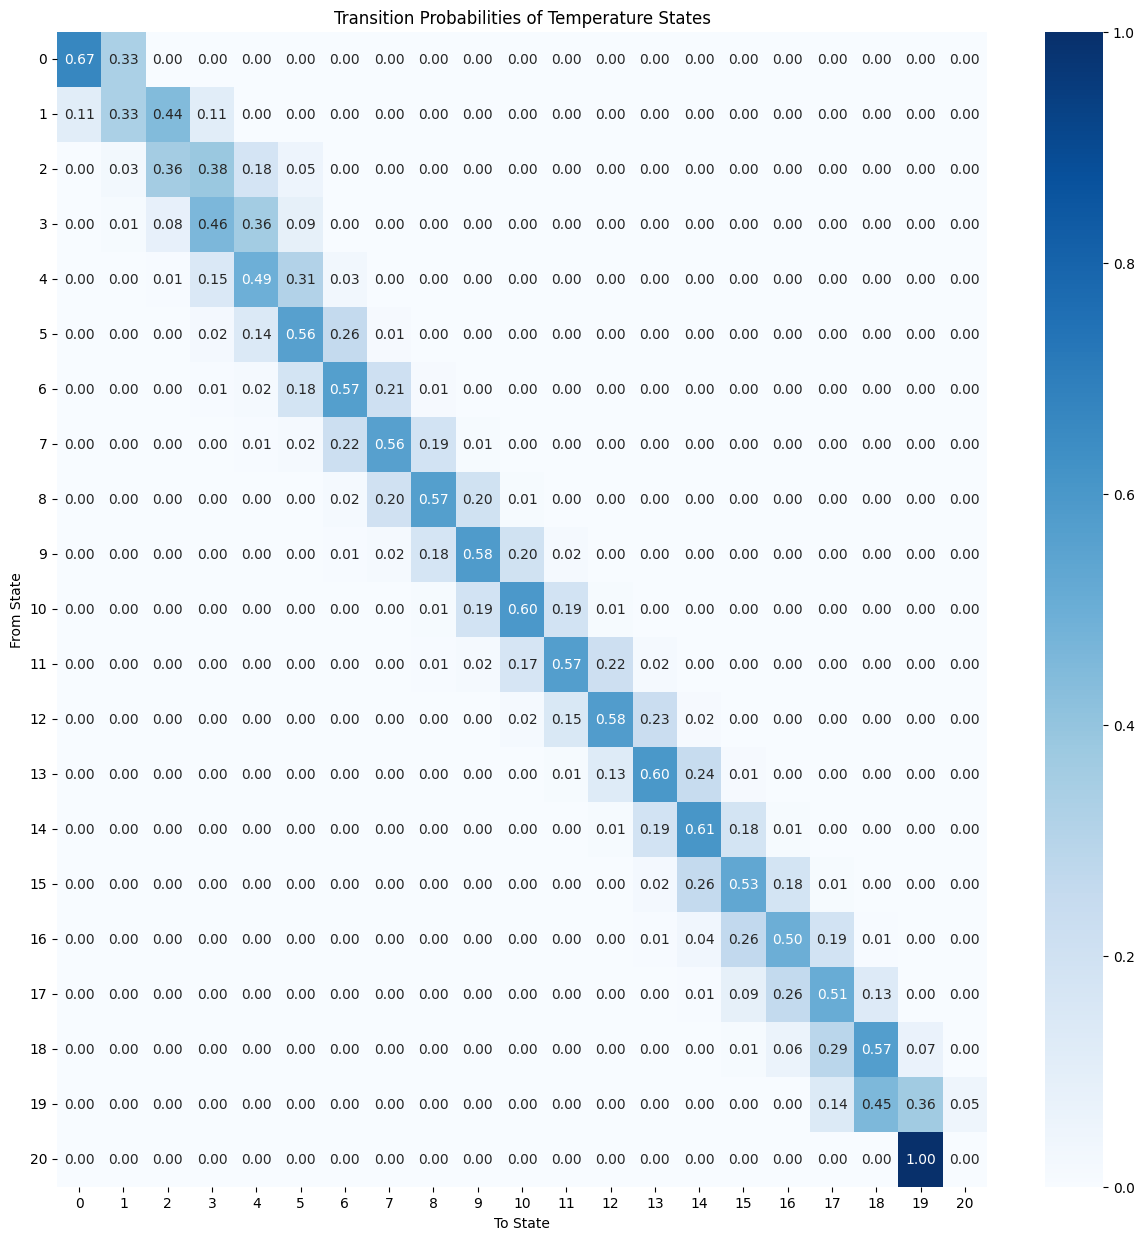

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

num_bins = 20  # You can adjust the number of bins as needed

discretized_data, temperature_bins = discretize_temperature_data(train_data, variable='T2M', num_bins = 20)

# Set the order of the Markov chain model  this means looks at the current state to predict the next state
order = 1  # You can adjust this value as needed

# Train the Markov chain model
model = train_markov_chain(discretized_data, order)

# # Plot the transistion matrix
plot_transistion_matrix(model)


In [ ]:
# Define possible temperature states
states = np.arange(1, num_bins + 1)

# Set the initial state for prediction
initial_state = np.random.choice(states)

# Predict future temperature trend for three year (1095 days)
predicted_trend = predict_temperature_trend(model, initial_state, steps=1095)

# Convert predicted temperature trend to DataFrame with dates
start_date = pd.to_datetime('2021-01-01')
date_range = pd.date_range(start_date, periods=1096)  # Include the initial date as well
predicted_df = pd.DataFrame({'Date': date_range[:-1], 'T2M': temperature_bins[np.array(predicted_trend) - 1][:len(date_range) - 1]})

# # Plot actual and predicted temperature trends
# plot_actual_and_predicted_temperature(df_2023, predicted_df)



In [ ]:
predicted_df.tail()

,Date,T2M
1090,2023-12-27,22.3130
1091,2023-12-28,21.0135
1092,2023-12-29,22.3130
1093,2023-12-30,22.3130
1094,2023-12-31,22.3130


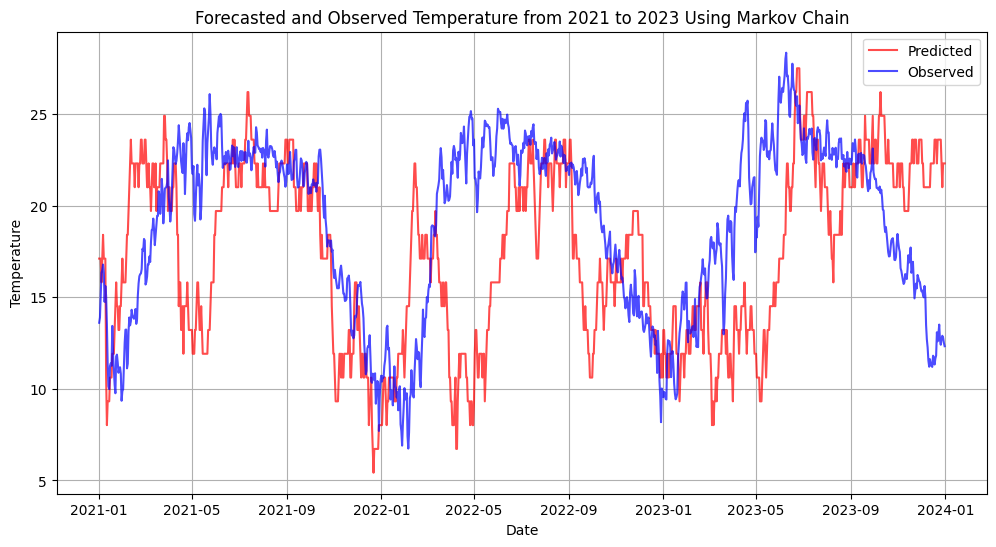

In [ ]:
plt.figure(figsize=(12, 6))

# Plot predicted temperatures for 2024
plt.plot(predicted_df['Date'], predicted_df['T2M'], label='Predicted', color='red', alpha=0.7)

# Plot observed temperatures
plt.plot(test_data['Date'], test_data['T2M'], label='Observed', color='blue', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecasted and Observed Temperature from 2021 to 2023 Using Markov Chain')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate accuracy by comparing forecasted and observed temperatures
def calculate_accuracy(forecasted_temperatures, observed_temperatures):
    # For simplicity, let's assume some measure of error (e.g., Mean Absolute Error)
    errors = np.abs(forecasted_temperatures - observed_temperatures)
    accuracy = 100 - np.mean(errors)
    return accuracy

# Calculate accuracy for the forecasted temperatures
accuracy = calculate_accuracy(predicted_df['T2M'], test_data['T2M'])

print("Accuracy of forecasted temperatures: {:.2f}%".format(accuracy))

Accuracy of forecasted temperatures: 95.64%


In [ ]:
# Assuming df contains the actual temperature data for 2023
# Calculate MAE and RMSE
mae = mean_absolute_error(test_data['T2M'], predicted_df['T2M'])
mse = mean_squared_error(test_data['T2M'], predicted_df['T2M'])
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Square Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 4.357662100456621
Mean Square Error: 32.21176660593608
Root Mean Squared Error: 5.675541084860198


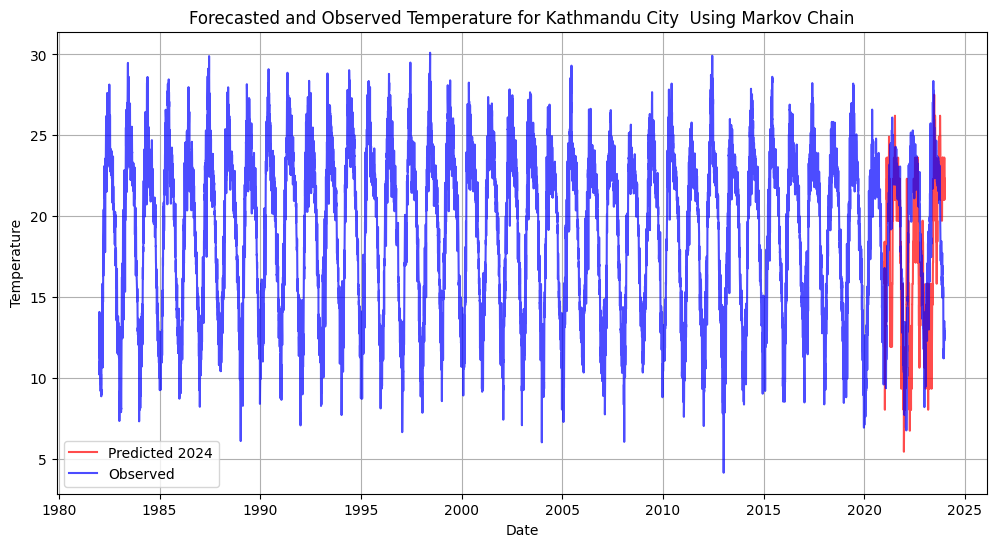

In [ ]:
plt.figure(figsize=(12, 6))

# Plot predicted temperatures for 2024
plt.plot(predicted_df['Date'], predicted_df['T2M'], label='Predicted', color='red', alpha=0.7)

# Plot observed temperatures
plt.plot(df['Date'], df['T2M'], label='Observed', color='blue', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecasted and Observed Temperature for Kathmandu City  Using Markov Chain')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate the overlap between training and testing data based on date range
overlap = len(train_data) / (len(train_data) + len(test_data)) * 100

print("Overlap between training and testing data: {:.2f}%".format(overlap))


Overlap between training and testing data: 92.86%
